## 1. Read in Graph Data

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [3]:
EGO_USER = 0 

# Load pickled (adj, feat) tuple
network_dir = './fb-processed/{0}-adj-feat.pkl'.format(EGO_USER)

adj,features=pd.read_pickle(network_dir)

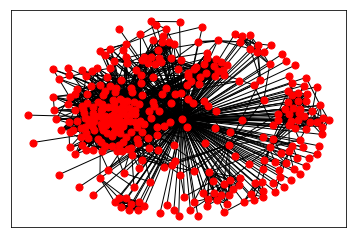

In [4]:
# draw network
g = nx.Graph(adj)
nx.draw_networkx(g, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Data Preprocessing

In [5]:
from __future__ import division
from __future__ import print_function

import time
import os

# Train on CPU (hide GPU) due to memory constraints


import tensorflow as tf
tf.set_random_seed(0)
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

from gae.optimizer import OptimizerAE, OptimizerVAE
from gae.model import GCNModelAE, GCNModelVAE
from gae.preprocessing import preprocess_graph, construct_feed_dict, sparse_to_tuple, mask_test_edges

c:\users\phani\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\phani\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\phani\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\phani\appd

In [6]:
# Convert features from normal matrix --> sparse matrix --> tuple
    # features_tuple contains: (list of matrix coordinates, list of values, matrix dimensions)
import scipy.sparse as sp
x = sp.lil_matrix(features)
features_tuple = sparse_to_tuple(x)
features_shape = features_tuple[2]

In [7]:
# Get graph attributes (to feed into model)
num_nodes = adj.shape[0] 
num_features = features_shape[1] # number of features (columsn of features matrix)
features_nonzero = features_tuple[1].shape[0] 

In [8]:
# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj
adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape)
adj_orig.eliminate_zeros()

np.random.seed(0) #  train/test splits
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)

# Normalize adjacency matrix
adj_norm = preprocess_graph(adj_train)


adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

In [9]:
# Inspect train/test split
print("Total nodes:", adj.shape[0])
print("Total edges:", int(adj.nnz/2)) 
print("Training edges (positive):", len(train_edges))
print("Training edges (negative):", len(train_edges_false))
print("Validation edges (positive):", len(val_edges))
print("Validation edges (negative):", len(val_edges_false))
print("Test edges (positive):", len(test_edges))
print("Test edges (negative):", len(test_edges_false))

Total nodes: 348
Total edges: 2866
Training edges (positive): 1721
Training edges (negative): 1721
Validation edges (positive): 286
Validation edges (negative): 286
Test edges (positive): 859
Test edges (negative): 859


## 3. Initialize VAE Model

In [10]:
# Define hyperparameters
LEARNING_RATE = 0.005
EPOCHS = 300
HIDDEN1_DIM = 32
HIDDEN2_DIM = 16
DROPOUT = 0.1

In [11]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

In [12]:

pos_weight = float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()

# normalize (scale) average weighted cost
norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)

In [13]:
# Create VAE model
model = GCNModelVAE(placeholders, num_features, num_nodes, features_nonzero,
                   HIDDEN1_DIM, HIDDEN2_DIM)

opt = OptimizerVAE(preds=model.reconstructions,
                           labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'],
                                                                       validate_indices=False), [-1]),
                           model=model, num_nodes=num_nodes,
                           pos_weight=pos_weight,
                           norm=norm,
                           learning_rate=LEARNING_RATE)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Creating GAE optimizer...
Labels shape:  (?,)
Preds shape:  (121104,)
CE+KL loss shape:  ()
Instructions for updating:
Use tf.cast instead.


In [14]:
# Calculate ROC AUC
def get_roc_score(edges_pos, edges_neg, emb=None):
    if emb is None:
        feed_dict.update({placeholders['dropout']: 0})
        emb = sess.run(model.z_mean, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        pos.append(adj_orig[e[0], e[1]]) # actual value (1)

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]])) # predicted score for given edge
        neg.append(adj_orig[e[0], e[1]]) # actual value (0)

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

## 4. Train and Evaluate VAE Model

In [15]:
cost_val = []
acc_val = []
val_roc_score = []

# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Train model
for epoch in range(EPOCHS):

    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features_tuple, placeholders)
    feed_dict.update({placeholders['dropout']: DROPOUT})
    # Run single weight update
    outs = sess.run([opt.opt_op, opt.cost, opt.accuracy], feed_dict=feed_dict)

    # Compute average loss
    avg_cost = outs[1]
    avg_accuracy = outs[2]

    # Evaluate predictions
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)
    val_roc_score.append(roc_curr)

    # Print results for this epoch
    print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(avg_cost),
          "train_acc=", "{:.5f}".format(avg_accuracy), "val_roc=", "{:.5f}".format(val_roc_score[-1]),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print("Optimization Finished!")

# Print final results
roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: ' + str(roc_score))
print('Test AP score: ' + str(ap_score))

Epoch: 0001 train_loss= 1.40993 train_acc= 0.40971 val_roc= 0.81627 val_ap= 0.83978 time= 0.50477
Epoch: 0002 train_loss= 1.27896 train_acc= 0.43407 val_roc= 0.82229 val_ap= 0.84682 time= 0.07278
Epoch: 0003 train_loss= 1.17231 train_acc= 0.44276 val_roc= 0.82515 val_ap= 0.85140 time= 0.06828
Epoch: 0004 train_loss= 1.16718 train_acc= 0.44449 val_roc= 0.82685 val_ap= 0.85415 time= 0.09659
Epoch: 0005 train_loss= 1.04009 train_acc= 0.44154 val_roc= 0.82786 val_ap= 0.85564 time= 0.06523
Epoch: 0006 train_loss= 1.00560 train_acc= 0.43596 val_roc= 0.82937 val_ap= 0.85774 time= 0.06147
Epoch: 0007 train_loss= 0.97337 train_acc= 0.42768 val_roc= 0.83081 val_ap= 0.85894 time= 0.07503
Epoch: 0008 train_loss= 0.89278 train_acc= 0.43452 val_roc= 0.83294 val_ap= 0.85984 time= 0.07988
Epoch: 0009 train_loss= 0.84625 train_acc= 0.43194 val_roc= 0.83719 val_ap= 0.86186 time= 0.07041
Epoch: 0010 train_loss= 0.80704 train_acc= 0.43828 val_roc= 0.84436 val_ap= 0.86483 time= 0.05452
Epoch: 0011 train_lo

Epoch: 0086 train_loss= 0.54139 train_acc= 0.53333 val_roc= 0.87273 val_ap= 0.88028 time= 0.12234
Epoch: 0087 train_loss= 0.54066 train_acc= 0.53529 val_roc= 0.87386 val_ap= 0.88197 time= 0.10118
Epoch: 0088 train_loss= 0.54087 train_acc= 0.52593 val_roc= 0.87483 val_ap= 0.88274 time= 0.06763
Epoch: 0089 train_loss= 0.53983 train_acc= 0.53113 val_roc= 0.87438 val_ap= 0.88166 time= 0.06215
Epoch: 0090 train_loss= 0.54066 train_acc= 0.53281 val_roc= 0.87101 val_ap= 0.87861 time= 0.08105
Epoch: 0091 train_loss= 0.54102 train_acc= 0.53245 val_roc= 0.86597 val_ap= 0.87575 time= 0.09205
Epoch: 0092 train_loss= 0.54189 train_acc= 0.52913 val_roc= 0.86413 val_ap= 0.87443 time= 0.07591
Epoch: 0093 train_loss= 0.53939 train_acc= 0.53409 val_roc= 0.86804 val_ap= 0.87701 time= 0.07149
Epoch: 0094 train_loss= 0.53667 train_acc= 0.53290 val_roc= 0.86943 val_ap= 0.87805 time= 0.06748
Epoch: 0095 train_loss= 0.53948 train_acc= 0.52778 val_roc= 0.86935 val_ap= 0.87872 time= 0.06733
Epoch: 0096 train_lo

Epoch: 0171 train_loss= 0.52684 train_acc= 0.54049 val_roc= 0.86464 val_ap= 0.88163 time= 0.05763
Epoch: 0172 train_loss= 0.52716 train_acc= 0.54120 val_roc= 0.86970 val_ap= 0.88477 time= 0.06090
Epoch: 0173 train_loss= 0.52473 train_acc= 0.53952 val_roc= 0.87413 val_ap= 0.88806 time= 0.05755
Epoch: 0174 train_loss= 0.53077 train_acc= 0.53389 val_roc= 0.87354 val_ap= 0.88726 time= 0.04855
Epoch: 0175 train_loss= 0.52712 train_acc= 0.55044 val_roc= 0.87156 val_ap= 0.88575 time= 0.05458
Epoch: 0176 train_loss= 0.52700 train_acc= 0.54305 val_roc= 0.86604 val_ap= 0.88141 time= 0.05854
Epoch: 0177 train_loss= 0.52901 train_acc= 0.54087 val_roc= 0.86415 val_ap= 0.87964 time= 0.07077
Epoch: 0178 train_loss= 0.52697 train_acc= 0.54505 val_roc= 0.86618 val_ap= 0.88066 time= 0.06278
Epoch: 0179 train_loss= 0.52780 train_acc= 0.54130 val_roc= 0.86900 val_ap= 0.88248 time= 0.05823
Epoch: 0180 train_loss= 0.52544 train_acc= 0.54269 val_roc= 0.87279 val_ap= 0.88561 time= 0.04284
Epoch: 0181 train_lo

Epoch: 0257 train_loss= 0.52553 train_acc= 0.52968 val_roc= 0.87196 val_ap= 0.88666 time= 0.06546
Epoch: 0258 train_loss= 0.51958 train_acc= 0.54963 val_roc= 0.87403 val_ap= 0.88856 time= 0.06239
Epoch: 0259 train_loss= 0.51929 train_acc= 0.53747 val_roc= 0.87475 val_ap= 0.88955 time= 0.05650
Epoch: 0260 train_loss= 0.51862 train_acc= 0.54958 val_roc= 0.87756 val_ap= 0.89170 time= 0.06584
Epoch: 0261 train_loss= 0.52036 train_acc= 0.54400 val_roc= 0.87913 val_ap= 0.89304 time= 0.04472
Epoch: 0262 train_loss= 0.52491 train_acc= 0.53868 val_roc= 0.87843 val_ap= 0.89240 time= 0.06392
Epoch: 0263 train_loss= 0.52165 train_acc= 0.54730 val_roc= 0.87771 val_ap= 0.89202 time= 0.05204
Epoch: 0264 train_loss= 0.52042 train_acc= 0.54634 val_roc= 0.87370 val_ap= 0.88925 time= 0.05709
Epoch: 0265 train_loss= 0.52269 train_acc= 0.53283 val_roc= 0.86960 val_ap= 0.88676 time= 0.05151
Epoch: 0266 train_loss= 0.51932 train_acc= 0.54877 val_roc= 0.86739 val_ap= 0.88479 time= 0.07282
Epoch: 0267 train_lo